## Key Takeaways
* It's easy to forget that virtually all asset classes we hold are priced in US dollar terms.  Portfolio valuations are as impacted by the _denominator_ (US dollars) as by the numerator (asset value)
* Commodity assets like oil and gold are highly (negatively) correlated to US dollar strength.  
* Certain equity asset classes, especially emerging equities, are extremely negatively correlated to USD strength
* Asset class performance can look much different in any given quarter or year when adjusting for currency

## Introduction

US-based investors can easily forget the impact of USD exchange rates on their portfolio returns - and forget that their portfolios are valued in numbers of US dollars.  On a day where the US dollar rises sharply against major currencies, prices of gold, oil, and international stocks often appear to _fall_ sharply.  

For instance, the number of US dollars it took to buy an ounce of gold (using GLD as proxy) lost 6.8% in the second quarter of 2018, but that coincided with the value of each of those US dollars (using UUP as proxy) gained 6.2%.  It could be said that the actual value of gold didn't do much of anything last quarter.  

#### __GLD vs. UUP, Q2 2018__  
<img src="images/GLD_UUP.png" width="600"> 
_source: Yahoo Finance_

Serious investors in gold and other commodities do, in my observation, understand the importance of FX.  However, many equity investors are unaware that the same effect holds for their stocks and bonds.  

In this post, I'll explore the impact of US dollar strength on a variety of traditional asset classes, and will re-examine 2017 and 2018 YTD using a currency-agnostic point of view.  

_If you'd like to replicate and experiment with the below code, you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/03_Feature_Selection.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>


In [1]:

## Replace this section of imports with your preferred
## data download/access interface.  This calls a 
## proprietary set of methods (ie they won't work for you)
import sys
sys.path.append('/anaconda/')
import config

sys.path.append(config.REPO_ROOT+'data/')
from prices.eod import read

####### Below here are standard python packages ######
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import seaborn as sns

from IPython.core.display import HTML,Image

### Prepare Data

We'll start by gathering EOD prices (adjusted for splits and dividends) for ~20 index ETFs as well as UUP, an ETF which tracks the US dollar against a basket of global currencies.  I'll then translate these prices into log returns for easy compounding.  

Next, I'll calculate a beta coefficient for each symbol (excluding UUP itself) vs. UUP.  

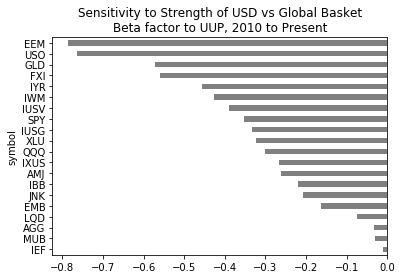

In [2]:
## Replace this with a call to your preferred end of day data source

symbols = ['SPY','IUSG','IUSV','IWM','QQQ','AGG','LQD','JNK','IEF','MUB','FXI','EEM','EMB','IXUS','GLD','USO','IYR','AMJ','XLU','IBB','UUP']
prices = read.get_symbols_close(symbols,adjusted=True)
#returns = prices.pct_change()
log_ret = np.log(prices).diff()

cov = log_ret['2010':].cov()['UUP'].rename('covariance') # covariance of 
var = log_ret['UUP'].var()
hedge_ratios = cov / var
hedge_ratios.name = 'hedge_ratios'

#pd.concat([cov,hedge_ratios],axis=1).sort_values('hedge_ratios')
hedge_ratios.sort_values().drop('UUP').sort_values(ascending=False)\
.plot.barh(color='grey',title='Sensitivity to Strength of USD vs Global Basket\
\nBeta factor to UUP, 2010 to Present')

The results are interesting and a bit surprising.  GLD, for instance, has a beta of -0.57 meaning that the price of GLD tends to fall 0.57% in a period when UUP gains 1.00%.  This yields a few notable results:
* Emerging markets equities (EEM) are the most sensitive to US dollar changes - much more than non-US equities (IXUS) or emerging market debt (EMB)
* Oil (USO) is considerably more sensitive to USD than gold
* Of the major equity indices, IWM (small cap) is considerably more sensitive than is SPY (large cap) - and both are more sensitive than QQQ (tech-heavy NASDAQ)
* IYR (real estate) is, perhaps unsurprisingly, quite sensitive
* Value stocks (IUSV) are more sensitive than growth stocks (IUSG) by a small fraction



### A global perspective on the current decade

Using these beta factors, we can re-state the asset class total returns ex-currency.  To do this, I will first calculate the daily (log) returns of UUP, then map and multiply with the beta factors, and calculate a pro forma (ex-currency effect) daily return.  

The below heatmaps present returns in three ways:
1. Actual historical returns (log)
2. Marginal favorable (unfavorable) impact of currency effects
3. Pro-forma returns, excluding currency effects

For clarity, the ETFs most sensitive to currency rates are presented at left.


Text(0.5,1,'Pro Forma Annual Total Returns\n Adjusted for Currency Effect (%)')

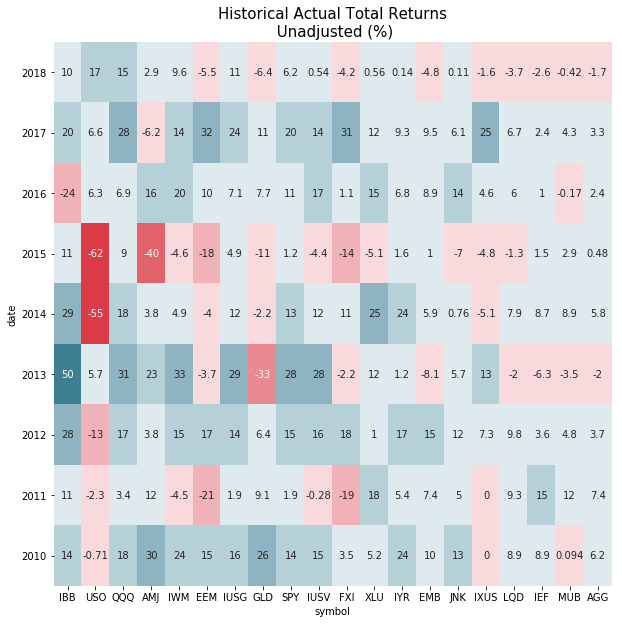

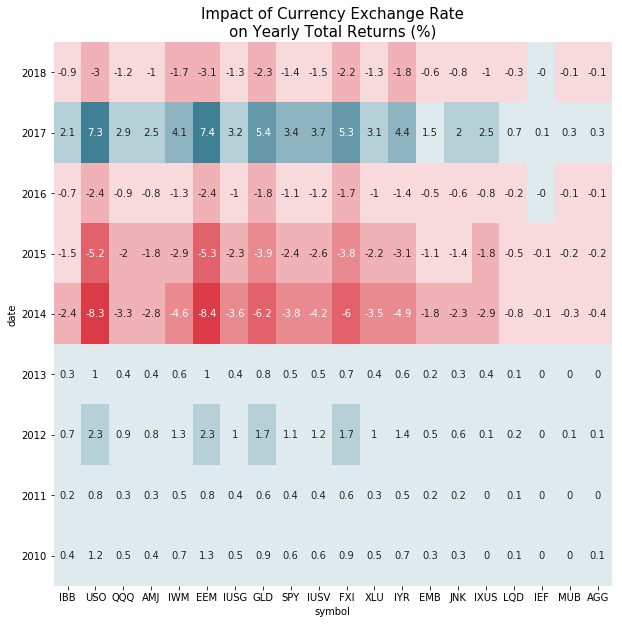

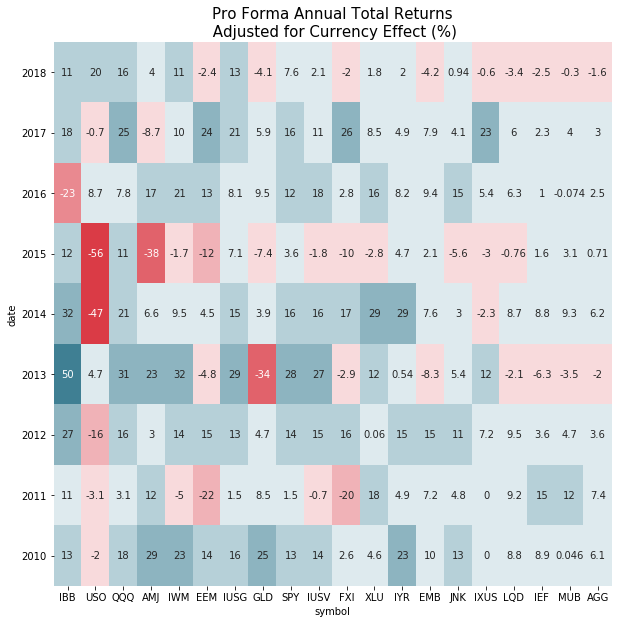

In [8]:
# adjust returns ex-UUP impact
log_ret_uup = log_ret['2010':]['UUP']

df = log_ret['2010':].stack().to_frame(name='log_ret')\
.join(hedge_ratios).join(log_ret_uup).dropna()

df['adj_ret'] = df.log_ret-(df.UUP*df.hedge_ratios)

rets = df.log_ret.unstack()
rets_fx_adj = df.adj_ret.unstack()


# Actual historical total log-returns 
fig, ax = plt.subplots(figsize=(10,10))  
df_plot =(df.log_ret.unstack().resample('A').sum())\
.multiply(100).round(3).sort_index(ascending=False)

avg_impact = df_plot.abs().mean().sort_values(ascending=False).drop('UUP')

df_plot = df_plot[avg_impact.index] #reorder with most impacted at left

df_plot.index = df_plot.index.map(lambda t: t.strftime('%Y'))
sns.heatmap(df_plot,annot =True,cmap=sns.diverging_palette(10, 220, sep=5, n=10),\
            cbar=False,center=0)
plt.yticks(rotation=0) 
plt.title('Historical Actual Total Returns\n Unadjusted (%)', fontsize=15)


# Plot the positive (negative) impact of currency effects per fund, per year
fig, ax = plt.subplots(figsize=(10,10))  

df_plot =(df.log_ret.unstack().resample('A').sum() \
          - df.adj_ret.unstack().resample('A').sum())\
.round(3).multiply(100).sort_index(ascending=False) 

df_plot = df_plot[avg_impact.index] #reorder with most impacted at left

df_plot.index = df_plot.index.map(lambda t: t.strftime('%Y'))
sns.heatmap(df_plot,annot =True,cmap=sns.diverging_palette(10, 220, sep=5, n=10),\
            cbar=False,center=0)
plt.yticks(rotation=0) 
plt.title('Impact of Currency Exchange Rate\non Yearly Total Returns (%)', fontsize=15)

# Calculate pro-forma total returns, adjusted for currency value changes
fig, ax = plt.subplots(figsize=(10,10))  
df_plot =(df.adj_ret.unstack().resample('A').sum()).multiply(100).round(3).sort_index(ascending=False) 
df_plot = df_plot[avg_impact.index] #reorder with most impacted at left

df_plot.index = df_plot.index.map(lambda t: t.strftime('%Y'))
sns.heatmap(df_plot,annot =True,cmap=sns.diverging_palette(10, 220, sep=5, n=10),\
            cbar=False,center=0)
plt.yticks(rotation=0) 
plt.title('Pro Forma Annual Total Returns\n Adjusted for Currency Effect (%)', fontsize=15)

As an example of reading these tables, EEM in 2018 has lost 6.3% YTD (time-weighted).  However, 2.9% of that decline can be attributed to currency rate changes, leaving only -3.3% of decline in asset class value.  

Some of the +/- impacts are quite significant in individual years, though these impacts tend to cancel out over multi-year periods (USD exchange rates have been more or less stationary in the past decade).  

The below chart shows cumulative returns for EEM, as an example.  Depending on your definition of "material", this difference meets that bar.  

Actual Return                    23.258579
Returns Adjusted for Currency    29.626147
Name: 2018-12-31 00:00:00, dtype: float64


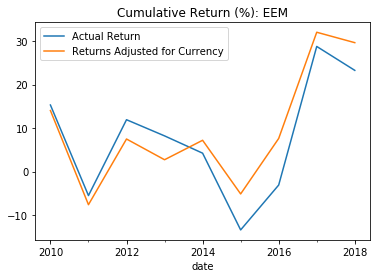

In [9]:
symbol = 'EEM'

df = pd.DataFrame({'Actual Return':rets.resample('A').sum().stack(),'Returns Adjusted for Currency':rets_fx_adj.resample('A').sum().stack()})
#df['diff'] = df.returns - df.returns_fx_adjusted
(df.xs(symbol,level='symbol')*100).cumsum().plot(title='Cumulative Return (%): {}'.format(symbol))
print((df.xs(symbol,level='symbol')*100).cumsum().iloc[-1])

## Conclusion
It's easy to forget that virtually all asset classes we hold are priced in US dollar terms.  Portfolio valuations are as impacted by the _denominator_ (US dollars) as by the numerator (asset value).  

Commodity assets like oil and gold are highly (negatively) correlated to US dollar strength.  But many equity asset classes, especially emerging equities, are even more strongly negatively correlated to USD strength.  These relationships can skew both short and long term performance.   

Even investors who are willing to ignore currency-driven changes in portfolio value (perhaps because their expenditures are also denominated in US dollars...) should be aware of the currency-driven covariance between currency-sensitive instruments.  A seemingly diversified portfolio of emerging equities, gold, real estate, and small caps would be remarkably exposed to changes in exchange rates.   

## One last thing...

If you've found this post interesting, please follow [@data2alpha](https://twitter.com/data2alpha) on twitter and forward to a friend or colleague who may also find this topic relevant.

Finally, take a minute to leave a comment below.  Share your thoughts on this post or to offer an idea for future posts.  Thanks for reading!